# Aim

Ignore the downloaded data; instead, try to replicate the methods of Ballard (2018).

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize, stats, special
import pandas as pd
import pymultinest
import emcee
%matplotlib inline

In [2]:
# constants and frozen parameters, like the bins

Go4pi = 2945.4625385377644/(4 * np.pi * np.pi)
MsoMe_cbrt = 69.31
rng_p = np.array([0.5, 200])
rng_r = np.array([0.5, 4])
num_bins_p = 13
num_bins_r = 17
N1 = 1
sigma1 = 0
N2 = 6.1
sigma2 = 2
fs = 0.55
mixture_params = {"N1": N1, "sigma1": sigma1, "N2": N2, "sigma2": sigma2, "fs": fs}
bins_p = np.exp(np.linspace(*np.log(rng_p), num_bins_p))
bins_r = np.exp(np.linspace(*np.log(rng_r), num_bins_r))

In [3]:
def make_synth_solar_systems(mixture_params=mixture_params, num_stars=10000, mstar=0.4):
    '''
    Makes a synthetic solar system from frozen parameters.
    Follows an empirical distribution, and assumes occurrence is either Pop 1 or Pop 2.
    '''
    rstar = 0.9535 * mstar + 0.0053535 # quick linear fit on the Kepler stellar catalog, filtered on mass bw 0.3 and 0.5 Msuns
    num_pop_1 = int(num_stars * mixture_params['fs'])
    num_pop_2 = num_stars - num_pop_1
    nums_planets = np.empty((0,))
    eccs = np.empty((0,))
    for N, sigma, num_pop in [(mixture_params['N1'], sigma1, num_pop_1), 
                              (mixture_params['N2'], sigma2, num_pop_2)]:
        frac = N % 1
        num_floor = int(num_pop * (1 - frac))
        nums_planets = np.hstack((nums_planets, np.floor(N) * np.ones(num_floor,), np.ceil(N) * np.ones(num_pop - num_floor))).astype(dtype=np.int8)
        # eccs = np.hstack((eccs, stats.rayleigh(scale=sigma, size=num_pop))) # He, Ford, Ragozzine
    ecc_means = 0.584 * np.repeat(nums_planets, nums_planets) ** (-1.2) # Limbach and Turner
    eccs = np.random.rayleigh(np.sqrt(2 / np.pi) * ecc_means)
    num_planets = sum(nums_planets)
    periods = np.exp(np.random.uniform(*np.log(rng_p), size=(num_planets,))) # in days
    prads = np.exp(np.random.uniform(*np.log(rng_r), size=(num_planets,))) # in R_Earths
    pmass = np.maximum(0.8, 2.7 * prads ** 1.3 + np.random.normal(0, 1.9, size=(num_planets,))) # ignoring Zeng/Jacobsen
    system_inds = np.cumsum(nums_planets)
    solar_sys_ids = []
    for i, ind in enumerate(nums_planets):
        solar_sys_ids += [i] * ind
    stabilities = 2 * MsoMe_cbrt * ((periods[1:] ** (2/3) - periods[:-1] ** (2/3)) / (periods[1:] ** (2/3) + periods[:-1] ** (2/3))) * (3 * mstar / (pmass[:-1] + pmass[1:]))
    unstable_inds = np.where(np.logical_and((np.abs(stabilities) <= 2 * np.sqrt(3)), ([x in system_inds for x in range(len(stabilities))])))[0]
    # may need to sort in period order?
    while len(unstable_inds) > 0:
        replace_periods = np.exp(np.random.uniform(*np.log(rng_p), size=(len(unstable_inds),)))
        replace_prads = np.exp(np.random.uniform(*np.log(rng_r), size=(len(unstable_inds),)))
        replace_pmass = 2.7 * replace_prads ** 1.3 + np.random.normal(0, 1.9, size=(len(unstable_inds),)) # ignoring Zeng/Jacobsen
        periods[unstable_inds] = replace_periods
        prads[unstable_inds] = replace_prads
        pmass[unstable_inds] = replace_pmass
        stabilities = 2 * MsoMe_cbrt * ((periods[1:] ** (2/3) - periods[:-1] ** (2/3)) / (periods[1:] ** (2/3) + periods[:-1] ** (2/3))) * (3 * mstar / (pmass[:-1] + pmass[1:]))
        unstable_inds = np.where(np.logical_and((np.abs(stabilities) <= 2 * np.sqrt(3)), ([x in system_inds for x in range(len(stabilities))])))[0]
    a = (Go4pi * periods * periods * mstar) ** (1./3)
    transit_bool = a / rstar * (1 - eccs ** 2) <= 1
    ttv = np.random.binomial(n = 1, p = [{1: 0.035, 2: 0.07, 3: 0.08}.get(x) if x < 4 else 0.104 for x in np.repeat(nums_planets, nums_planets)], size=(num_planets,))
    # densities = (stabilities / 22) ** 6 #size mismatch
    return pd.DataFrame({
                        "ids" : solar_sys_ids,
                        "periods" : periods, 
                         "prads" : prads, 
                         "pmass" : pmass, 
                         "eccs" : eccs,
                         "a" : a, 
                         "transit_bool" : transit_bool,
                         "ttv" : ttv, 
                        })

synth_solsys = make_synth_solar_systems()



In [4]:
# downloaded from http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=J/ApJ/809/77
sullivan_catalog = np.loadtxt('sullivan_catalog.dat')
cols = ["alpha", "delta", "rp", "P", "SoSsun", "K", "rs", "teff", "V", "Ic", "J", "Ks", "DM", "Dil.", "log10_sigmav", "SNR", "mult"]
sullivan_catalog = pd.DataFrame({x: sullivan_catalog[:,i] for i, x in enumerate(cols)})
sullivan_catalog

,alpha,delta,rp,P,SoSsun,K,rs,teff,V,Ic,J,Ks,DM,Dil.,log10_sigmav,SNR,mult
0,0.4390,45.22,3.311,9.135,361.700,2.031,1.4130,6531.0,8.471,7.974,7.630,7.415,5.00,1.001,-4.870,16.840,1.0
1,0.4803,-66.20,2.187,14.200,2.053,3.111,0.3214,3426.0,15.080,12.830,11.560,10.790,3.90,1.009,-4.219,12.320,3.0
2,0.6458,42.94,1.743,4.957,235.000,1.660,0.9550,5546.0,10.120,9.346,8.807,8.415,4.95,1.001,-4.644,7.547,0.0
3,0.9241,-26.07,1.475,2.160,1240.000,1.945,1.1250,5984.0,8.065,7.424,6.976,6.667,3.65,1.000,-4.502,8.371,0.0
4,1.3140,-24.95,2.288,9.753,5.917,2.951,0.4243,3622.0,14.190,12.150,10.990,10.190,4.10,1.000,-4.439,8.626,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1979,358.9000,43.11,2.813,4.260,31.980,4.160,0.5249,3886.0,12.810,11.050,10.010,9.197,3.80,1.003,-4.517,26.570,3.0
1980,359.0000,-70.18,2.300,10.760,4.701,3.014,0.4037,3578.0,13.290,11.220,10.040,9.251,3.00,1.000,-4.559,23.140,3.0
1981,359.1000,-16.81,2.134,3.196,11.680,5.496,0.2786,3376.0,15.840,13.520,12.220,11.450,4.20,1.000,-3.622,9.328,0.0
1982,359.6000,-15.61,3.705,12.120,29.220,2.995,0.7103,4911.0,11.900,10.820,10.130,9.531,5.25,1.000,-4.239,18.710,0.0


Text(0.5, 1.0, "Ballard's initial distribution of injected planets")

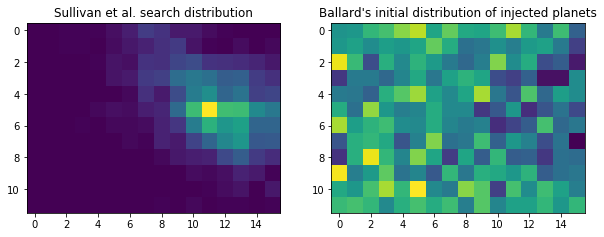

In [5]:
hist2d_ballard = np.histogram2d(synth_solsys.periods, synth_solsys.prads, bins=[bins_p, bins_r])
hist2d_sullivan = np.histogram2d(sullivan_catalog.P, sullivan_catalog.rp, bins=[bins_p, bins_r])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.imshow(hist2d_sullivan[0])
ax1.set_title("Sullivan et al. search distribution")
ax2.imshow(hist2d_ballard[0])
ax2.set_title("Ballard's initial distribution of injected planets")

In [14]:
D = hist2d_sullivan[0]
N = hist2d_ballard[0]
log_fact_D = special.gammaln(D + 1)
eps_ll = -1e10

comp_poly = lambda x, a1, a2, a3, a4: a4 + a1 * x + (a1 * a2) * x ** 2 + (a1/3) * (a2**2 + a3**2) * x ** 3

def ll(a):
    a_period, a_radius = a[:4], a[4:]
    comp_p, comp_r = comp_poly(bins_p[:-1], *a_period), comp_poly(bins_r[:-1], *a_radius)
    has_negative = np.any(comp_p < 0) or np.any(comp_r < 0)
    is_not_monotonic = not np.all(np.diff(comp_p) < 0) or not np.all(np.diff(comp_r) > 0)
    if has_negative:
        return -1e15
    comp = np.outer(comp_p, comp_r)
    if np.any(comp < 0):
        return -1e15
    mu = N * comp
    if np.any(mu <= 0):
        return -1e15
    ll_mat = D * np.log(mu) - mu - log_fact_D
    return np.sum(ll_mat)

ndim = 8
nwalkers = 16
optimize_result = optimize.minimize(lambda x: -ll(x), [1, 0, 0, 0, 1, 0, 0, 0], method='Nelder-Mead', options={"maxiter" :10000})
leastsq_sol = optimize_result.x

def prior(a):
    return np.all(np.isfinite(a)) and np.all(np.abs(leastsq_sol - a) < 2 * leastsq_sol)

def ll_with_prior(a):
    if not prior(a):
        return 0
    return ll(a)

sampler = emcee.EnsembleSampler(nwalkers, ndim, ll_with_prior)
p0 = leastsq_sol + np.random.normal(0, 1e-3, size=(nwalkers, ndim))
sampler.run_mcmc(p0, 1000)

State([[ 7.06717457e+135 -7.28481036e+135 -7.47235237e+135  6.05276325e+135
  -9.04063396e+135 -4.61575318e+135 -2.60400155e+135 -8.82340757e+135]
 [ 7.62517431e+134 -7.85999386e+134 -8.06234355e+134  6.53066857e+134
  -9.75445125e+134 -4.98019714e+134 -2.80960453e+134 -9.52007340e+134]
 [-2.04881003e+133  2.11190375e+133  2.16627314e+133 -1.75472700e+133
   2.62092599e+133  1.33813044e+133  7.54913356e+132  2.55795095e+133]
 [-1.35355628e+135  1.39523946e+135  1.43115886e+135 -1.15926890e+135
   1.73152747e+135  8.84042364e+134  4.98737171e+134  1.68992270e+135]
 [-1.18298518e+135  1.21941557e+135  1.25080851e+135 -1.01318132e+135
   1.51332557e+135  7.72637998e+134  4.35887809e+134  1.47696371e+135]
 [-1.13689455e+135  1.17190557e+135  1.20207540e+135 -9.73706465e+134
   1.45436446e+135  7.42535025e+134  4.18905058e+134  1.41941930e+135]
 [ 1.51992993e+135 -1.56673663e+135 -1.60707110e+135  1.30176153e+135
  -1.94435980e+135 -9.92705264e+134 -5.60039920e+134 -1.89764114e+135]
 [ 1.51

In [ ]:
leastsq_sol